# Word vectors from SEC filings using gensim

In this section, we will learn word and phrase vectors from annual SEC filings using gensim to illustrate the potential value of word embeddings for algorithmic trading. In the following sections, we will combine these vectors as features with price returns to train neural networks to predict equity prices from the content of security filings.

In particular, we use a dataset containing over 22,000 10-K annual reports from the period 2013-2016 that are filed by listed companies and contain both financial information and management commentary (see chapter 3 on Alternative Data). For about half of 11K filings for companies that we have stock prices to label the data for predictive modeling

## Imports & Settings

In [24]:
from dateutil.relativedelta import relativedelta
from pathlib import Path
import numpy as np
import pandas as pd
from time import time
from collections import Counter
import logging
import spacy

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser

In [2]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

In [3]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

### Logging Setup

In [4]:
logging.basicConfig(
        filename='preprocessing.log',
        level=logging.DEBUG,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%H:%M:%S')

## Data Download

The data can be downloaded from [here](https://drive.google.com/uc?id=0B4NK0q0tDtLFendmeHNsYzNVZ2M&export=download). Unzip, move into `data` folder and rename to `filings`.

### Paths

Each filing is a separate text file and a master index contains filing metadata. We extract the most informative sections, namely
- Item 1 and 1A: Business and Risk Factors
- Item 7 and 7A: Management's Discussion and Disclosures about Market Risks

The notebook preprocessing shows how to parse and tokenize the text using spaCy, similar to the approach in chapter 14. We do not lemmatize the tokens to preserve nuances of word usage.

We use gensim to detect phrases. The Phrases module scores the tokens and the Phraser class transforms the text data accordingly. The notebook shows how to repeat the process to create longer phrases.

In [5]:
sec_path = Path('data', 'sec-filings')
data_path = sec_path / 'data'
filing_path = data_path / 'filings'
sections_path = data_path / 'sections'

In [6]:
if not sections_path.exists():
    sections_path.mkdir(exist_ok=True, parents=True)

## Identify Sections

In [7]:
for i, filing in enumerate(filing_path.glob('*.txt'), 1):
    if i % 500 == 0:
        print(i, end=' ', flush=True)
    filing_id = int(filing.stem)
    items = {}
    for section in filing.read_text().lower().split('°'):
        if section.startswith('item '):
            if len(section.split()) > 1:
                item = section.split()[1].replace('.', '').replace(':', '').replace(',', '')
                text = ' '.join([t for t in section.split()[2:]])
                if items.get(item) is None or len(items.get(item)) < len(text):
                    items[item] = text

    txt = pd.Series(items).reset_index()
    txt.columns = ['item', 'text']
    txt.to_csv(sections_path / (filing.stem + '.csv'), index=False)

## Parse Sections

Select the following sections:

In [8]:
sections = ['1', '1a', '7', '7a']

In [9]:
clean_path = data_path / 'selected_sections'
if not clean_path.exists():
    clean_path.mkdir(exist_ok=True)

In [10]:
nlp = spacy.load('en', disable=['ner'])
nlp.max_length = 6000000

In [11]:
vocab = Counter()
t = total_tokens = 0
stats = []

start = time()
to_do = len(list(sections_path.glob('*.csv')))
done = len(list(sections_path.glob('*.csv')))
for text_file in sections_path.glob('*.csv'):
    file_id = int(text_file.stem)
    clean_file = clean_path / f'{file_id}.csv'
    if clean_file.exists():
        continue
    items = pd.read_csv(text_file).dropna()
    items.item = items.item.astype(str)
    items = items[items.item.isin(sections)]
    if done % 100 == 0:
        duration = time() - start
        to_go = (to_do - done) * duration / done
        print(f'{done:>5}\t{format_time(duration)}\t{total_tokens / duration:,.0f}\t{format_time(to_go)}')
    
    clean_doc = []
    for _, (item, text) in items.iterrows():
        doc = nlp(text)
        for s, sentence in enumerate(doc.sents):
            clean_sentence = []
            if sentence is not None:
                for t, token in enumerate(sentence, 1):
                    if not any([token.is_stop,
                                token.is_digit,
                                not token.is_alpha,
                                token.is_punct,
                                token.is_space,
                                token.lemma_ == '-PRON-',
                                token.pos_ in ['PUNCT', 'SYM', 'X']]):
                        clean_sentence.append(token.text.lower())
                total_tokens += t
                if len(clean_sentence) > 0:
                    clean_doc.append([item, s, ' '.join(clean_sentence)])
    (pd.DataFrame(clean_doc,
                  columns=['item', 'sentence', 'text'])
     .dropna()
     .to_csv(clean_file, index=False))
    done += 1

## Create ngrams

In [12]:
ngram_path = data_path / 'ngrams'
stats_path = sec_path / 'corpus_stats'
for path in [ngram_path, stats_path]:
    if not path.exists():
        path.mkdir(parents=Treu)

In [13]:
unigrams = ngram_path / 'ngrams_1.txt'

In [20]:
def create_unigrams(min_length=3):
    texts = []
    sentence_counter = Counter()
    vocab = Counter()
    for i, f in enumerate(clean_path.glob('*.csv')):
        if i % 1000 == 0:
            print(i, end=' ', flush=True)
        df = pd.read_csv(f)
        df.item = df.item.astype(str)
        df = df[df.item.isin(sections)]
        sentence_counter.update(df.groupby('item').size().to_dict())
        for sentence in df.text.dropna().str.split().tolist():
            if len(sentence) >= min_length:
                vocab.update(sentence)
                texts.append(' '.join(sentence))
    
    (pd.DataFrame(sentence_counter.most_common(), 
                  columns=['item', 'sentences'])
     .to_csv(stats_path / 'selected_sentences.csv', index=False))
    (pd.DataFrame(vocab.most_common(), columns=['token', 'n'])
     .to_csv(stats_path / 'sections_vocab.csv', index=False))
    
    unigrams.write_text('\n'.join(texts))
    return [l.split() for l in texts]

In [21]:
start = time()
if not unigrams.exists():
    texts = create_unigrams()
else:
    texts = [l.split() for l in unigrams.open()]
print('\nReading: ', format_time(time() - start))

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 Reading:  00:03:51


In [35]:
def create_ngrams(max_length=3):
    """Using gensim to create ngrams"""

    n_grams = pd.DataFrame()
    start = time()
    for n in range(2, max_length + 1):
        print(n, end=' ', flush=True)

        sentences = LineSentence(ngram_path / f'ngrams_{n - 1}.txt')
        phrases = Phrases(sentences=sentences,
                          min_count=25,  # ignore terms with a lower count
                          threshold=0.5,  # accept phrases with higher score
                          max_vocab_size=40000000,  # prune of less common words to limit memory use
                          delimiter=b'_',  # how to join ngram tokens
                          progress_per=50000,  # log progress every
                          scoring='npmi')

        s = pd.DataFrame([[k.decode('utf-8'), v]
                          for k, v in phrases.export_phrases(sentences)]
                         , columns=['phrase', 'score']).assign(length=n)

        n_grams = pd.concat([n_grams, s])
        grams = Phraser(phrases)
        sentences = grams[sentences]
        (ngram_path / f'ngrams_{n}.txt').write_text('\n'.join([' '.join(s) for s in sentences]))

    n_grams = n_grams.sort_values('score', ascending=False)
    n_grams.phrase = n_grams.phrase.str.replace('_', ' ')
    n_grams['ngram'] = n_grams.phrase.str.replace(' ', '_')

    n_grams.to_parquet(data_path / 'ngrams.parquet')

    print('\n\tDuration: ', format_time(time() - start))
    print('\tngrams: {:,d}\n'.format(len(n_grams)))
    print(n_grams.groupby('length').size())

In [36]:
create_ngrams()

2 3 
	Duration:  00:49:34
	ngrams: 38,631,962

length
2    27740526
3    10891436
dtype: int64


## Inspect Corpus

In [37]:
nsents, ntokens = Counter(), Counter()
for f in clean_path.glob('*.csv'):
    df = pd.read_csv(f)
    nsents.update({str(k): v for k, v in df.item.value_counts().to_dict().items()})
    df['ntokens'] = df.text.str.split().str.len()
    ntokens.update({str(k): v for k, v in df.groupby('item').ntokens.sum().to_dict().items()})

In [38]:
ntokens = pd.DataFrame(ntokens.most_common(), columns=['Item', '# Tokens'])
nsents = pd.DataFrame(nsents.most_common(), columns=['Item', '# Sentences'])

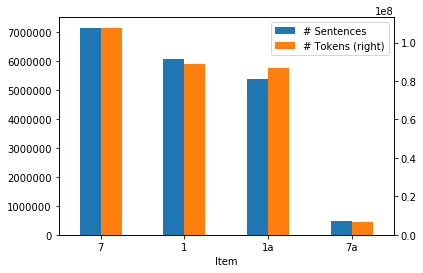

In [39]:
nsents.set_index('Item').join(ntokens.set_index('Item')).plot.bar(secondary_y='# Tokens', rot=0);

In [41]:
ngrams = pd.read_parquet(data_path / 'ngrams.parquet')

In [42]:
ngrams.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38631962 entries, 9727751 to 15565228
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   phrase  object 
 1   score   float64
 2   length  int64  
 3   ngram   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.4+ GB


In [47]:
ngrams.head()

,phrase,score,length,ngram
9727751,seasons punta mita resort,1.0,3,seasons_punta_mita_resort
2111772,compels removal lawful billboard,1.0,3,compels_removal_lawful_billboard
1883872,india sri lanka,1.0,3,india_sri_lanka
1883874,india sri lanka,1.0,3,india_sri_lanka
1883876,india sri lanka,1.0,3,india_sri_lanka


In [43]:
percentiles=np.arange(.1, 1, .1).round(2)
ngrams.score.describe(percentiles=percentiles)

count    3.863196e+07
mean     6.591030e-01
std      1.267509e-01
min      5.000002e-01
10%      5.164282e-01
20%      5.363954e-01
30%      5.637752e-01
40%      5.924836e-01
50%      6.235732e-01
60%      6.748381e-01
70%      7.190586e-01
80%      7.832695e-01
90%      8.396440e-01
max      1.000000e+00
Name: score, dtype: float64

In [44]:
ngrams[ngrams.score>.7].sort_values(['length', 'score']).head(10)

,phrase,score,length,ngram
15151151,einstein bros,0.700053,2,einstein_bros
15151109,einstein bros,0.700053,2,einstein_bros
15151039,einstein bros,0.700053,2,einstein_bros
535508,einstein bros,0.700053,2,einstein_bros
15151260,einstein bros,0.700053,2,einstein_bros
535560,einstein bros,0.700053,2,einstein_bros
15151038,einstein bros,0.700053,2,einstein_bros
15151063,einstein bros,0.700053,2,einstein_bros
15151102,einstein bros,0.700053,2,einstein_bros
535566,einstein bros,0.700053,2,einstein_bros


In [48]:
vocab = pd.read_csv(stats_path / 'sections_vocab.csv').dropna()

In [49]:
vocab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200829 entries, 0 to 200830
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   token   200829 non-null  object
 1   n       200829 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


In [50]:
vocab.n.describe(percentiles).astype(int)

count     200829
mean        1440
std        22343
min            1
10%            1
20%            2
30%            3
40%            4
50%            7
60%           12
70%           24
80%           61
90%          259
max      2574546
Name: n, dtype: int64

In [52]:
tokens = Counter()
for l in (ngram_path / 'ngrams_3.txt').open():
    tokens.update(l.split())

In [53]:
tokens = pd.DataFrame(tokens.most_common(),
                     columns=['token', 'count'])

In [54]:
tokens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247885 entries, 0 to 247884
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   token   247885 non-null  object
 1   count   247885 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.8+ MB


In [55]:
tokens.head()

,token,count
0,million,2340243
1,business,1646311
2,company,1462659
3,products,1368711
4,including,1110482


In [56]:
tokens.loc[tokens.token.str.contains('_'), 'count'].describe(percentiles).astype(int)

count     47780
mean        627
std        6563
min           1
10%          19
20%          28
30%          33
40%          40
50%          52
60%          71
70%         106
80%         185
90%         492
max      513694
Name: count, dtype: int64

In [ ]:
tokens[tokens.token.str.contains('_')].head(20).to_csv('ngram_examples.csv', index=False)

In [57]:
tokens[tokens.token.str.contains('_')].head(20)

,token,count
51,year_ended_december,513694
64,table_contents,437690
71,company_s,413921
115,fair_value,303973
127,common_stock,288689
148,united_states,260930
166,cash_flows,238992
172,approximately_million,234303
181,adversely_affect,228139
182,results_operations,227066


## Get returns

In [62]:
DATA_FOLDER = Path('..', 'data')

In [63]:
with pd.HDFStore(DATA_FOLDER / 'assets.h5') as store:
    prices = store['quandl/wiki/prices'].adj_close

In [64]:
sec = pd.read_csv(data_path / 'filing_index.csv').rename(columns=str.lower)
sec.date_filed = pd.to_datetime(sec.date_filed)

In [65]:
sec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22631 entries, 0 to 22630
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cik           22631 non-null  int64         
 1   company_name  22631 non-null  object        
 2   form_type     22631 non-null  object        
 3   date_filed    22631 non-null  datetime64[ns]
 4   edgar_link    22631 non-null  object        
 5   quarter       22631 non-null  int64         
 6   ticker        22631 non-null  object        
 7   sic           22461 non-null  object        
 8   exchange      20619 non-null  object        
 9   hits          22555 non-null  object        
 10  year          22631 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 1.9+ MB


In [66]:
idx = pd.IndexSlice

In [68]:
first = sec.date_filed.min() + relativedelta(months=-1)
last = sec.date_filed.max() + relativedelta(months=1)
prices = (prices
          .loc[idx[first:last, :]]
          .unstack().resample('D')
          .ffill()
          .dropna(how='all', axis=1)
          .filter(sec.ticker.unique()))

In [69]:
sec = sec.loc[sec.ticker.isin(prices.columns), ['ticker', 'date_filed']]

price_data = []
for ticker, date in sec.values.tolist():
    target = date + relativedelta(months=1)
    s = prices.loc[date: target, ticker]
    price_data.append(s.iloc[-1] / s.iloc[0] - 1)

df = pd.DataFrame(price_data,
                  columns=['returns'],
                  index=sec.index)

In [70]:
df.returns.describe()       

count    11101.000000
mean         0.022839
std          0.126137
min         -0.555556
25%         -0.032213
50%          0.017349
75%          0.067330
max          1.928826
Name: returns, dtype: float64

In [71]:
sec['returns'] = price_data
sec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11375 entries, 0 to 22629
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ticker      11375 non-null  object        
 1   date_filed  11375 non-null  datetime64[ns]
 2   returns     11101 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 355.5+ KB


In [ ]:
sec.dropna().to_csv(data_path / 'sec_returns.csv', index=False)